In [18]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.io import loadmat
from scipy.ndimage import convolve
from scipy.misc import imread,imresize,imfilter

In [134]:
def load_image2(path,size = 256,smooth = True, sigma =1, gray = True):
    '''
    Input=>
    path: image address
    size: Integer, dimension of output img: default= 256
    smooth: Boolean, Used gaussian blurring: default = True 
    sigma: Number, std for gaussian filter, default = 1
    gray: Boolean, image should be gray or color, default = True
    Output=>
    Numpy array of image as per inputs
    '''
    img = imread(path)
    img = imresize(img,(size,size))
    if smooth:
        img = cv2.GaussianBlur(img,(5,5),sigma)
    if gray:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return img    

In [129]:
def localMaxSup2d(mat,threshold):
    '''
    return dict with key = tuple(y,x) and val = value
    '''
    r_mat = mat
    offset2 = 1
    height = r_mat.shape[0]
    width = r_mat.shape[1]
    r_val_dict = None
    r_val_dict = dict()
    for y in range(offset2,height-offset2):
        for x in range(offset2,width-offset2):
            if r_mat[y,x] < threshold or r_mat[y,x]==0:
                continue
                
            xmin = x-offset2
            xmax = x+offset2+1
            ymin = y-offset2
            ymax = y+offset2+1
            localMax = np.max(r_mat[ymin:ymax,xmin:xmax])
            if localMax > r_mat[y,x]:
                r_mat[y,x] = 0
            else:
                r_val_dict[(y,x)] = r_mat[y,x]
    return r_val_dict

In [138]:
def extract_keypoints(img,t_percentile=99):
    '''
    Used sobel filter for edge detection
    Input: 
    1: Image with color channel is RGB
    2: Optional percentile for thresholding
    Output: img, r_val_dict, intrestPt[:,0], intrestPt[:,1], scores, Ix, Iy
    1: grayScale output image
    2: dictionary of key = (y,x) and values = Rscore
    3: x vector
    4: y vector
    5: R scores for corrosponding x and y
    6: gradient Ix
    7: gradient Iy
    
    '''
    image = img.copy()
    if image.ndim > 2:
        image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img = image.copy()
    og_img = image.copy()
    windowSize = 5
    k = 0.05
    
    #Ix,Iy = np.gradient(image)
    Ix = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=windowSize)
    Iy = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=windowSize)
    
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Iy * Ix
    height = image.shape[0]
    width = image.shape[1]
    offset = windowSize//2
    r_mat = np.zeros_like(image,dtype=np.int64)
    r_val_dict = dict()
    for y in range(offset,height-offset):
        for x in range(offset,width-offset):
            m = np.zeros((2,2))
            xmin = x-offset
            xmax = x+offset+1
            ymin = y-offset
            ymax = y+offset+1

            local_Ixx = Ixx[ymin:ymax,xmin:xmax]
            local_Iyy = Iyy[ymin:ymax,xmin:xmax]
            local_Ixy = Ixy[ymin:ymax,xmin:xmax]
            Sxx = local_Ixx.sum()
            Sxy = local_Ixy.sum()
            Syy = local_Iyy.sum()

            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            R = det - k*(trace**2)
            #R_val_dict[(y,x)] = R
            r_mat[y,x] = R
            
    threshold = np.percentile(r_mat,t_percentile)
    #print('sum of all the vals',np.sum(r_mat))
    r_mat[r_mat<threshold]=0
    #print("Printing after removal of value sless than threhold",np.sum(r_mat))
    r_val_dict = localMaxSup2d(r_mat,threshold)
    #print(r_val_dict)
    for k,v in r_val_dict.items():
        p,q = k
        cv2.circle(img,(q,p),3,255,-1)
    #plt.imshow(img)
    intrestPt = np.asarray([list(x) for x in r_val_dict.keys()])

#     global temp 
#     temp = intrestPt.copy()
    scores = np.array(list(r_val_dict.values()))
    return img,og_img, r_val_dict, intrestPt[:,0], intrestPt[:,1], scores, Ix, Iy
            
            

In [139]:
imgn = imread('img/star1.png')
imgn.ndim
#newimg,oldimg,keypoints_dict,PX,PY,RScore,Ix,Iy = extract_keypoints(imgn,98)



3

In [152]:
imgn = load_image2('img/star1.png',gray=False)
newimg,oldimg,keypoints_dict,PX,PY,RScore,Ix,Iy = extract_keypoints(imgn,98)

In [158]:
print(PX.shape[0])
print(len(keypoints_dict))
# print(np.zeros((PX.shape[0],8)))

58
58


In [151]:

img_copy = imgn.copy()
image_gray = cv2.cvtColor(imgn,cv2.COLOR_RGB2GRAY)


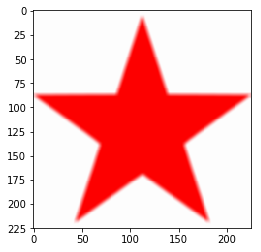

In [132]:
image_blur = cv2.GaussianBlur(imgn,(5,5),1)
plt.imshow(image_blur,cmap='gray')

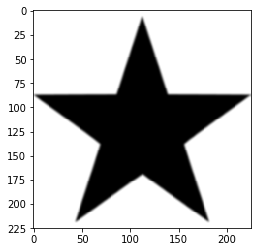

In [117]:
image_gray_blur = cv2.GaussianBlur(image_gray,(5,5),1)
plt.imshow(image_gray_blur,cmap='gray')

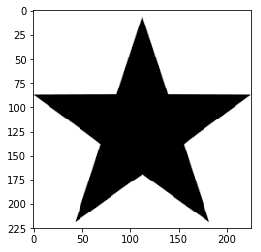

In [118]:

plt.imshow(image_gray,cmap='gray')

In [119]:
len(keypoints_dict)
Iy.shape[1]

225

In [120]:
def getBinMapping(theta):
    if theta<-67.5:
        return 'bin_m67'
    elif theta<-45:
        return 'bin_m45'
    elif theta<-22.5:
        return 'bin_m22'
    elif theta<-0:
        return 'bin_00'
    elif theta<22:
        return 'bin_22'
    elif theta<45:
        return 'bin_45'
    elif theta<67:
        return 'bin_67'
    else:
        return 'bin_90'
    
#test function for getBinMapping()
theta = np.degrees(np.arctan(-1))
print(theta)
siftbin = getBinMapping(theta)
print(siftbin)
    
# 'bin_m67':[],'bin_m45':[],'bin_m22':[],'bin_00':[],'bin_22':[],'bin_45':[],'bin_67':[],'bin_90'

-45.0
bin_m22


In [170]:
def getBinVector(bin_dict):
    finalVector = np.zeros((8))
    for binkey,binval in bin_dict.items():
        bin_dict[binkey] = sum(binval)
        if binkey == 'bin_m67':
            finalVector[0] = bin_dict[binkey]
        elif binkey == 'bin_m45':
            finalVector[1] = bin_dict[binkey]
        elif binkey == 'bin_m22':
            finalVector[2] = bin_dict[binkey]
        elif binkey == 'bin_00':
            finalVector[3] = bin_dict[binkey]
        elif binkey == 'bin_22':
            finalVector[4] = bin_dict[binkey]
        elif binkey == 'bin_45':
            finalVector[5] = bin_dict[binkey]
        elif binkey == 'bin_67':
            finalVector[6] = bin_dict[binkey]
        else:
            finalVector[7] = bin_dict[binkey]
        
   
    sumVal = np.sum(finalVector)
#     print('before normalization',finalVector)
    finalVector = finalVector/sumVal
#     print('after normalization',finalVector)
#     print("sum = ", np.sum(finalVector))
    clipVector = np.clip(finalVector,0,0.2)
#     print('Clip vector is', clipVector)
#     print("sum = ", np.sum(clipVector))
    return clipVector
    
#     print('finalVector',finalVector)
#     print('bin_dict',bin_dict)
    
#testing getBinVector()
zz = {'bin_m22': [11,22,33], 'bin_90': [0.0, 2.828, 15.875, 9.8, 3.873, 10.63, 10.195, 11.62, 8.43, 10.39, 11.31, 5.566, 13.96, 7.746, 7.55, 12.0, 12.0, 15.75, 14.0, 15.91, 15.875, 6.707, 8.72, 13.53, 10.44, 9.75, 7.81, 1.732, 13.71, 13.86, 5.918, 4.473, 11.664, 11.36, 15.49, 14.87, 11.31, 6.633, 11.31, 4.0, 15.97, 0.0, 3.465, 12.69, 9.95, 8.43, 13.266, 5.746, 13.266, 8.77, 0.0, 0.0, 0.0, 0.0, 5.746, 13.86, 10.73, 6.855, 15.49, 5.195], 'bin_m45': [], 'bin_00': [], 'bin_45': [15.91, 14.32, 15.586, 1.732, 15.78, 8.0, 8.25], 'bin_m67': [], 'bin_67': [0.0, 15.91, 1.732, 3.465, 8.305, 0.0, 8.664, 10.34, 15.97, 14.11, 15.4, 6.93, 12.04, 7.0, 14.734, 6.402, 14.97, 1.0, 10.82, 4.9, 5.656, 12.65, 10.73, 12.65, 15.0, 8.305, 12.0, 15.66, 10.39, 0.0], 'bin_22': [1.0, 1.0, 5.918]}
getBinVector(zz)



array([0.        , 0.        , 0.06753625, 0.        , 0.0081023 ,
       0.08143029, 0.2       , 0.2       ])

In [174]:
def compute_features(orig_blur_img,keypoints_dict,PX,PY,RScore,Ix,Iy):
    
    image_gray = orig_blur_img.copy()
    if image_gray.ndim > 2:
        image_gray = cv2.cvtColor(image_gray,cv2.COLOR_RGB2GRAY)
    image_gray_blur = image_gray
    
    maxSize =  Iy.shape[1]
    totalBins = 9
    normal_array = np.zeros((PX.shape[0],8)) 
    #made manual bins for easy debugging, It is not required but makes code flow simpler
    bin_dict = {'bin_m67':[],'bin_m45':[],'bin_m22':[],'bin_00':[],'bin_22':[],'bin_45':[],'bin_67':[],'bin_90':[]}

    finalBins_dict = dict()
    print("need some work/ help on the tan inverse function as they are not giving negative value")
    print("need some work/ help on co-ordinate of x and y")
    #creating a list of list to store bin data
    for index,(key,val) in enumerate(keypoints_dict.items()):
        bin_dict = {'bin_m67':[],'bin_m45':[],'bin_m22':[],'bin_00':[],'bin_22':[],'bin_45':[],'bin_67':[],'bin_90':[]}
        pointY,pointX = key
#         print(key)

        if (pointX - 5 < 0 or pointX + 5 > maxSize-1 or (pointY - 5) < 0 or (pointY + 5) > maxSize-1):
            print('descriptors cannot be found as feature too close to boundary')
            continue

        for x in range(pointX-5,pointX+5):
            for y in range(pointY-5,pointY+5):
                a = image_gray_blur[x+1,y]-image_gray_blur[x-1,y]
                b = image_gray_blur[x,y+1]-image_gray_blur[x,y-1]
                m = np.sqrt(np.square(a)+np.square(b))
                if (m < 0.01):
                    continue
                tanInv = np.arctan2((image_gray_blur[x,y+1] - image_gray_blur[x,y-1]),(image_gray_blur[x+1,y]-image_gray_blur[x-1,y]))
                theta = np.degrees(tanInv)
                siftbin = getBinMapping(theta)
                bin_dict[siftbin].append(m)

        finalBins_dict[key] = getBinVector(bin_dict)
        normal_array[index] = finalBins_dict[key]
        #print(finalBins_dict)
    return finalBins_dict,normal_array

    print('Done')

In [178]:
imgn = load_image2('img/cardinal1.jpg',gray=True)
newimg,oldimg,keypoints_dict,PX,PY,RScore,Ix,Iy = extract_keypoints(imgn,97)
finalBin,NormalizedArray = compute_features(imgn,keypoints_dict,PX,PY,RScore,Ix,Iy)


need some work/ help on the tan inverse function as they are not giving negative value
need some work/ help on co-ordinate of x and y
descriptors cannot be found as feature too close to boundary
descriptors cannot be found as feature too close to boundary
descriptors cannot be found as feature too close to boundary
descriptors cannot be found as feature too close to boundary
descriptors cannot be found as feature too close to boundary


In [179]:
NormalizedArray

array([[0.        , 0.        , 0.        , ..., 0.10573126, 0.14431114,
        0.2       ],
       [0.        , 0.        , 0.        , ..., 0.2       , 0.06823134,
        0.2       ],
       [0.        , 0.        , 0.        , ..., 0.13801692, 0.14077951,
        0.04484258],
       ...,
       [0.        , 0.        , 0.        , ..., 0.12223209, 0.2       ,
        0.2       ],
       [0.        , 0.        , 0.        , ..., 0.06956845, 0.2       ,
        0.19834819],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [147]:
bin_dct = {'bin_m67':[],'bin_m45':[],'bin_m22':[]}
len(bin_dct)
aa = np.zeros((len(bin_dct),8))
print(aa)
aa[0] = np.ones((8))
print(aa)
print()

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [143]:
def test_extractKP(pathVal,t_percentile=99,save = False):
    img1 = load_image2(pathVal)
    print(img1.shape)
    #img1 = imresize(img1,(256,256))
    print(img1.shape)
    newimg,oldimg,keypoints,a,b,c,d,e = extract_keypoints(img1,t_percentile)

    green = (0,255,0)
    newimgC = img1.copy()
    for k,v in keypoints.items():
        a,b =k
        cv2.circle(newimgC,(b,a),3,green)
    plt.figure(figsize=(20,40))
    plt.subplot(1,3,1)
    plt.title('Orignal')
    plt.imshow(img1)
    plt.subplot(1,3,2)
    plt.title("Corner Gray Scale")
    plt.imshow(newimg,cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Corner Green")
    plt.imshow(newimgC)
    if save:
        name = pathVal.split('/')[-1].split('.')[0]
        outname = 'outputImg\corner_'+name+'.jpg'
        plt.savefig(outname)

(256, 256)
(256, 256)


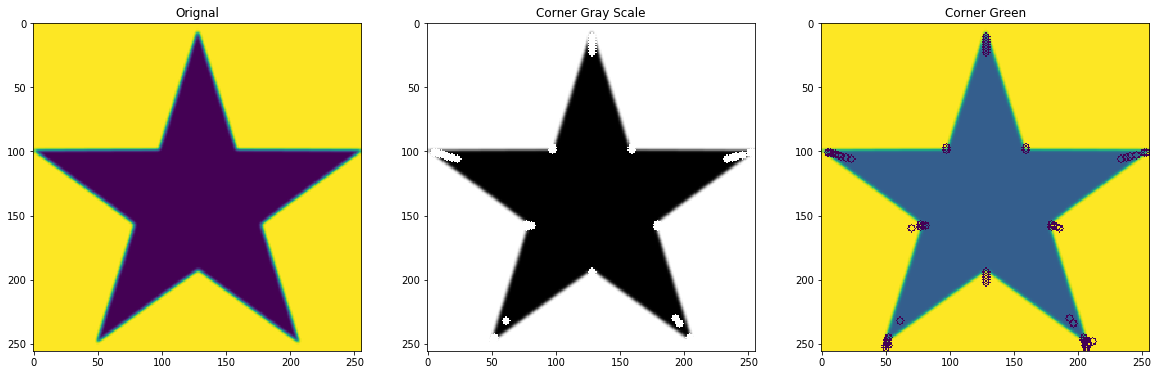

In [148]:
test_extractKP('img/star1.png')

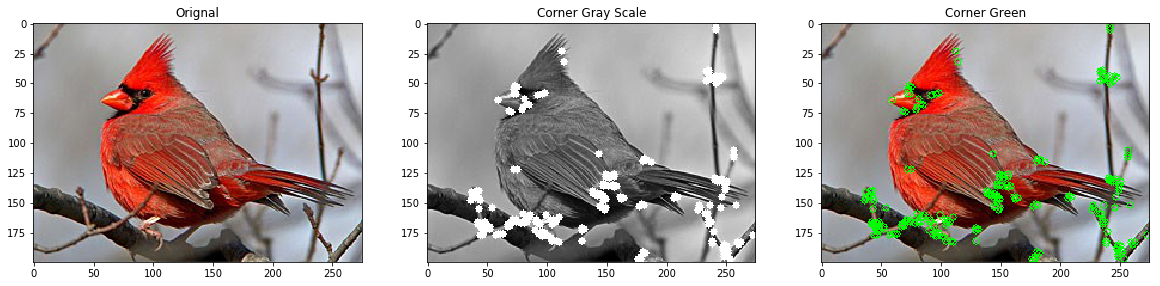

In [93]:
test_extractKP('img/cardinal1.jpg',97,save=True)

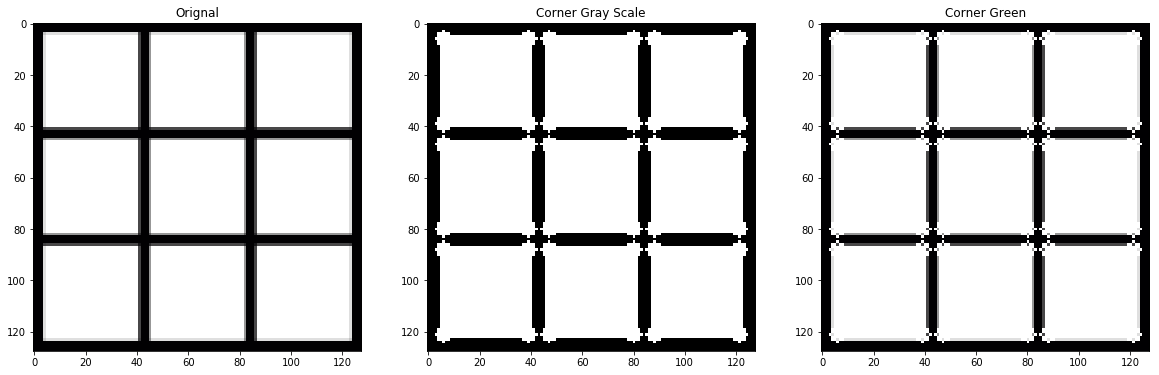

In [94]:
test_extractKP('img/sq1.png',save=True)

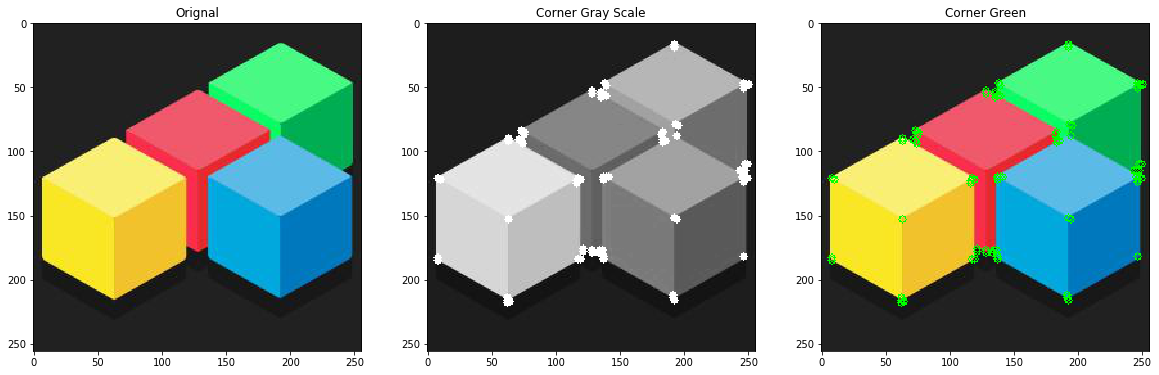

In [95]:
test_extractKP('img/blocks.jpg',save=True)

In [96]:
# abc = 'mg/star1.png'
# sp = abc.split('/')[-1].split('.')[0]
# nam = sp
# print(nam)

In [47]:
np.degrees((np.arctan(-10**10/0.0000001)))

-90.0

In [29]:
bin_dict = {'bin_m90':[],'bin_m67':[],'bin_m45':[],'bin_m22':[],'bin_00':[],'bin_22':[],'bin_45':[],'bin_67':[]}


In [32]:
bin_dict['bin_m90'].append('abc')

In [33]:
bin_dict

{'bin_m45': [], 'bin_m67': [], 'bin_m90': ['abc']}

In [59]:
#lot of trials
ii = 0
maxSize =  Iy.shape[1]
totalBins = 9

#made manual bins for easy debugging, It is not required but makes code flow simpler
bin_dict = {'bin_m67':[],'bin_m45':[],'bin_m22':[],'bin_00':[],'bin_22':[],'bin_45':[],'bin_67':[],'bin_90':[]}

finalBins_dict = dict()

#creating a list of list to store bin data
for key,val in keypoints_dict.items():
    bin_dict = {'bin_m67':[],'bin_m45':[],'bin_m22':[],'bin_00':[],'bin_22':[],'bin_45':[],'bin_67':[],'bin_90':[]}
    pointX,pointY = key
    print(key)
    
    if (pointX - 5 < 0 or pointX + 5 > maxSize-1 or (pointY - 5) < 0 or (pointY + 5) > maxSize-1):
        print('descriptors cannot be found as feature too close to boundary')
        continue
    
    for x in range(pointX-5,pointX+5):
        for y in range(pointY-5,pointY+5):
            a = image_gray_blur[x+1,y]-image_gray_blur[x-1,y]
            b = image_gray_blur[x,y+1]-image_gray_blur[x,y-1]
            m = np.sqrt(np.square(a)+np.square(b))
            if (m < 0.01):
                continue
            num = (image_gray_blur[x,y+1] - image_gray_blur[x,y-1])
            den = (image_gray_blur[x+1,y]-image_gray_blur[x-1,y])
            divi = 10*4
            if(den>0.0001):
                divi = num/den
            if (num < 0 or den <0):
                print('this is it')
                print('num',num)
                print('den',den)
                ii=10000
                break
                
            print('num',num)
            print('den',den)
            print('divi',divi)
            tanInv = np.arctan2((image_gray_blur[x,y+1] - image_gray_blur[x,y-1]),(image_gray_blur[x+1,y]-image_gray_blur[x-1,y]))
            print('tanInv',tanInv)
            theta = np.degrees(tanInv)
            siftbin = getBinMapping(theta)
            bin_dict[siftbin].append(m)

    finalBins_dict[key],temp_bin_dict = getBinVector(bin_dict)
    #print(finalBins_dict)
    print(ii)
    ii += 1
    if ii > 999:
        break
        

print('Done')

-45.0
bin_m22


In [ ]:
bin_dict1 = bin_dict.copy()
finalVector = np.zeros((8))
for binkey,binval in bin_dict.items():
    #bin_dict[binkey] = sum(binval)
    if binkey == 'bin_m67':
        finalVector[0] = bin_dict[binkey]
    elif binkey == 'bin_m45':
        finalVector[1] = bin_dict[binkey]
    elif binkey == 'bin_m22':
        finalVector[2] = bin_dict[binkey]
    elif binkey == 'bin_00':
        finalVector[3] = bin_dict[binkey]
    elif binkey == 'bin_22':
        finalVector[4] = bin_dict[binkey]
    elif binkey == 'bin_45':
        finalVector[5] = bin_dict[binkey]
    elif binkey == 'bin_67':
        finalVector[6] = bin_dict[binkey]
    else:
        finalVector[7] = bin_dict[binkey]

print(bin_dict)
print(finalVector)
print(bin_dict)
{'bin_m67':[],'bin_m45':[],'bin_m22':[],'bin_00':[],'bin_22':[],'bin_45':[],'bin_67':[],'bin_90':[]}